# IS4226 Group 9 Strategy 2
Nur Aliya Bte Mohd Wari (A0264656U, e1032468@u.nus.edu) \
Poh Mao Xin (A0216630N, e0540187@u.nus.edu) \
Tan Yi Xiang (A0276540A, e1132273@u.nus.edu) \
Wong Wei Hao (A0262004X, e0983398@u.nus.edu) 

## Strategy:
Mean reversion and momentum strategy. We would use indicators to identify undervalued stocks with Relative Strength Index (RSI) and Bollinger Bands (BB) and Volume Weighted Average Price (VWAP) and checking momentum with Exponential Moving Average (EMA).
### Buy
We would enter a buy position if the stock is undervalued and showing momentum to the upside. I.e. Long when RSI or BB or VWAP shows that a stock is oversold and supported by momentum using EMA. 
### Sell
We would enter a short position if the stock is overvalued and showing momentum to the downside. I.e. Short when RSI or BB or VWAP shows that a stock is overbought and supported by momentum using EMA

# Parameters for script

In [17]:
ANALYSIS_PERIOD = ("2015-01-01", "2019-12-31") # start date and end date respectively for analysis period

BENCHMARK_SYMBOL = "SPY" # used as market returns in calculations of alpha and beta
MAANG_SYMBOL = ["META","AMZN","AAPL","NFLX","GOOG"]

RISK_FREE_RATE = 0 # assumed to be 0, could also be estimated based on US t-bill rates

MINIMUM_ACCEPTABLE_RETURN = 0 # threshold for sortino ratio

DECIMAL_PLACES_TO_DISPLAY = 5 # number of decimals to round figures to

# Install commands

In [18]:
# !pip install yfinance
# !pip install ta

# Import Statements

In [19]:
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# Helper Functions

### General helper functions

In [20]:
# function to convert log returns to normal returns
def log_return_to_normal(log_returns):
    return np.exp(log_returns) - 1

# function to convert normal returns to log returns
def normal_return_to_log(normal_returns):
    return np.log(1 + normal_returns)

### Helper Functions for risk return statistics

In [21]:
# function to calculate annualised mean normal return from daily log returns
# - calculated with log returns
def calculate_annualised_mean_normal_return(log_returns):
    return log_return_to_normal(log_returns.mean() * 252)

# beta = covar(Rp, Rm) / var(Rm)
# - calculated with log returns
def calculate_beta(portfolio_log_returns, market_log_returns):
    return portfolio_log_returns.cov(market_log_returns) / market_log_returns.var()

# sharpe ratio = (Rp - Rf) / (SDp)
# - calculated with log returns
def calculate_annualised_sharpe_ratio(portfolio_log_returns, risk_free_rate): # annualised
    return 252**0.5 * (portfolio_log_returns.mean() - risk_free_rate) / portfolio_log_returns.std()

# alpha = Rp - Rf - beta * (Rm - Rf)
# - calculated with log returns
def calculate_annualised_alpha(portfolio_log_returns, risk_free_rate, market_log_returns): # annualised
    return 252 * (portfolio_log_returns.mean() - risk_free_rate - calculate_beta(portfolio_log_returns, market_log_returns) * (market_log_returns.mean() - risk_free_rate))

# standard deviation
# - calculated with log returns
def calculate_annualised_standard_deviation(portfolio_log_returns): # annualised
    return 252**0.5 * portfolio_log_returns.std()

# average daily normal returns
# - calculated using mean() method

# average daily log returns
# - calculated using mean() method

# draw down
# - calculated using cummax() and cumsum() methods

# Calmar Ratio = Returns / Drawdown
# - calculated with normal returns
def calculate_annualised_calmar_ratio(portfolio_log_returns, max_drawdown):
    return calculate_annualised_mean_normal_return(portfolio_log_returns)/max_drawdown

# Sortino Ratio = Returns / Neg_std_dev
# - calculated with normal returns
def calculate_annualised_sortino_ratio(portfolio_log_returns, minimum_acceptable_return):
    poor_returns = portfolio_log_returns[portfolio_log_returns < minimum_acceptable_return]
    annualised_neg_std_dev = np.sqrt(np.sum(poor_returns ** 2)/len(poor_returns)) * 252**0.5
    return calculate_annualised_mean_normal_return(portfolio_log_returns)/annualised_neg_std_dev

# Treynor Ratio = (Rp - Rf) / beta
# - calculated with normal returns
def calculate_annualised_treynor_ratio(portfolio_log_returns, risk_free_rate, market_log_returns):
    return 252 * (log_return_to_normal(portfolio_log_returns.mean()) - risk_free_rate) / calculate_beta(portfolio_log_returns, market_log_returns)

# Tracking error = standard deviation of (Rp - Rm)
# - calculated with normal returns
def calculate_tracking_error(portfolio_log_returns, market_log_returns):
    portfolio_normal_returns = log_return_to_normal(portfolio_log_returns)
    market_normal_returns = log_return_to_normal(market_log_returns)
    return (portfolio_normal_returns - market_normal_returns).std()

# Information Ratio = (Rp - Rm) / Tracking error
# - calculated with normal returns
def calculate_annualised_information_ratio(portfolio_log_returns, market_log_returns):
    return 252**0.5 * (log_return_to_normal(portfolio_log_returns) - log_return_to_normal(market_log_returns)).mean() / calculate_tracking_error(portfolio_log_returns, market_log_returns)

### Helper functions for indicators and trade strategy

In [22]:
# For EMA Crossover
def EMA(data: pd.DataFrame, window: int):
    return data.ewm(span=window).mean()

# For RSI
def RSI(data: pd.DataFrame, window: int):
    return RSIIndicator(data["Close"], window=window).rsi()

# For Bollinger Band
def bollinger(data: pd.DataFrame, size: int, std_dev: int):
    data = data.copy()
    sma = data.rolling(window=size).mean()
    rstd = data.rolling(window=size).std()
    upper_band = sma + std_dev * rstd
    lower_band = sma - std_dev * rstd
    sma = sma.rename(columns={'Close': 'BB_sma'})
    upper_band = upper_band.rename(columns={'Close': 'BB_upper'})
    lower_band = lower_band.rename(columns={'Close': 'BB_lower'})
    return pd.concat([sma, lower_band, upper_band], axis=1).dropna()

# For Volume Weighted Average Price
def VWAP(data: pd.DataFrame, window: int):
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    volume = data["Volume"]
    return VolumeWeightedAveragePrice(high, low, close, volume, window=window).volume_weighted_average_price()

# Retrieve necessary OHLC data

In [23]:
# Load OHLC data
spy_data = yf.Ticker(BENCHMARK_SYMBOL).history(start = ANALYSIS_PERIOD[0], end = ANALYSIS_PERIOD[1]) # Benchmark info (required for computation of alpha/beta of equal weighted MAANG portfolio and our strategy)

all_data = {}
for ticker in MAANG_SYMBOL:
    all_data[ticker] = yf.Ticker(ticker).history(start = ANALYSIS_PERIOD[0], end = ANALYSIS_PERIOD[1]) # MAANG info

# Calculate daily normal and log returns for SPY
spy_data["daily normal returns"] = spy_data["Close"].pct_change()
spy_data["daily log returns"] = np.log(spy_data['Close'] / spy_data['Close'].shift(1))

# Calculate daily normal and log returns for MAANG benchmark portfolio
for ticker in MAANG_SYMBOL:
    all_data[ticker]["daily normal returns"] = all_data[ticker]["Close"].pct_change()
    all_data[ticker]["daily log returns"] = np.log(all_data[ticker]['Close'] / all_data[ticker]['Close'].shift(1))

# Assess performance for equal weighted MAANG portfolio

In [24]:
# Combine MAANG log returns into a single DataFrame and calculate equally weighted portfolio log returns
maang_portfolio_log_returns = pd.concat([all_data[ticker]['daily log returns'] for ticker in MAANG_SYMBOL], axis=1).mean(axis=1)


# Compute individual stock beta (for computation of portfolio beta)
maang_beta = [calculate_beta(maang_portfolio_log_returns, spy_data['daily log returns'])] 

# Compute portfolio daily value (based on closing price) and daily returns (equal weighted returns from MAANG)
benchmark_portfolio = pd.DataFrame({
    "value": pd.concat([stock['Close'] for stock in all_data.values()], axis=1).mean(axis=1),
    "daily normal returns": pd.concat([stock['daily normal returns'] for stock in all_data.values()], axis=1).mean(axis=1),
    "daily log returns": pd.concat([stock['daily log returns'] for stock in all_data.values()], axis=1).mean(axis=1),
}, index=spy_data.index)

# Compute data required to analyse drawdown
benchmark_portfolio["cumulative returns"] = benchmark_portfolio["daily log returns"].cumsum()
benchmark_portfolio["maximum returns"] = benchmark_portfolio["cumulative returns"].cummax()
benchmark_portfolio["drawdown"] = benchmark_portfolio["maximum returns"] - benchmark_portfolio["cumulative returns"]

# Compute drawdown periods
benchmark_portfolio_current_drawdown_duration = 0
benchmark_portfolio_drawdown_periods = []
for is_drawdown in benchmark_portfolio["drawdown"] > 0:
    if is_drawdown:
        benchmark_portfolio_current_drawdown_duration += 1
    else:
        if benchmark_portfolio_current_drawdown_duration > 0:
            benchmark_portfolio_drawdown_periods.append(benchmark_portfolio_current_drawdown_duration)
        benchmark_portfolio_current_drawdown_duration = 0
if benchmark_portfolio_current_drawdown_duration > 0:
     benchmark_portfolio_drawdown_periods.append(benchmark_portfolio_current_drawdown_duration)

# Compute and display performance metrics for MAANG benchmark portfolio
print(f"MAANG benchmark portfolio performance from {ANALYSIS_PERIOD[0]} to {ANALYSIS_PERIOD[1]}:")
print(f" - Annual Mean Returns: {round(calculate_annualised_mean_normal_return(benchmark_portfolio['daily log returns']), DECIMAL_PLACES_TO_DISPLAY) * 100}%")
print(f" - Annual Standard Deviation: {round(calculate_annualised_standard_deviation(benchmark_portfolio['daily log returns']), DECIMAL_PLACES_TO_DISPLAY) * 100}")
print(f" - Beta: {round(sum(maang_beta)/len(maang_beta), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Alpha: {round(calculate_annualised_alpha(benchmark_portfolio['daily log returns'], RISK_FREE_RATE, spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Max Drawdown: {round(benchmark_portfolio['drawdown'].max(), DECIMAL_PLACES_TO_DISPLAY) * 100}")
print(f" - Max days of drawdown: {max(benchmark_portfolio_drawdown_periods) if benchmark_portfolio_drawdown_periods else 0}")
print()
print(f" - Sharpe Ratio (Annualised): {round(calculate_annualised_sharpe_ratio(benchmark_portfolio['daily log returns'], RISK_FREE_RATE), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Calmar Ratio (Annualised): {round(calculate_annualised_calmar_ratio(benchmark_portfolio['daily log returns'], benchmark_portfolio['drawdown'].max()), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Tracking Error: {round(calculate_tracking_error(benchmark_portfolio['daily log returns'], spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Information Ratio (Annualised): {round(calculate_annualised_information_ratio(benchmark_portfolio['daily log returns'], spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Treynor Ratio (Annualised): {round(calculate_annualised_treynor_ratio(benchmark_portfolio['daily log returns'], RISK_FREE_RATE, spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Sortino Ratio (Annualised): {round(calculate_annualised_sortino_ratio(benchmark_portfolio['daily log returns'], MINIMUM_ACCEPTABLE_RETURN), DECIMAL_PLACES_TO_DISPLAY)}")

MAANG benchmark portfolio performance from 2015-01-01 to 2019-12-31:
 - Annual Mean Returns: 30.424%
 - Annual Standard Deviation: 22.814999999999998
 - Beta: 1.29285
 - Alpha: 0.12423
 - Max Drawdown: 37.62
 - Max days of drawdown: 188

 - Sharpe Ratio (Annualised): 1.16422
 - Calmar Ratio (Annualised): 0.80872
 - Tracking Error: 0.00964
 - Information Ratio (Annualised): 1.1333
 - Treynor Ratio (Annualised): 0.20556
 - Sortino Ratio (Annualised): 1.24984


# Assess performance of Strategy 2

### Indicators used for trading signals

In [25]:
# For EMA Crossover
ema_fast_window = 10
ema_slow_window = 30

# For RSI
rsi_window = 14
rsi_buy_level = 30 #low level
rsi_sell_level = 70 #High level

# For Bollinger Band
bb_sma = 15
bb_std_dev = 2

# For Volume Weighted Average Price
vwap_window = 14

### Portfolio Returns using Strategy 2

#### Overview
This code performs backtesting of a trading strategy based on technical indicators for a set of stocks. It calculates various indicators, generates trading signals, and computes the returns for each stock. The results are consolidated into a DataFrame called strategy_portfolio, which holds the strategy's performance metrics.

#### Data Structures
strategy_portfolio (DataFrame): A Pandas DataFrame that stores the cumulative returns of the trading strategy for each stock.
all_data (dict): A dictionary containing historical stock data for multiple stocks, with each stock represented as a DataFrame.

#### Key Components
1. Indicator Calculations:
    - Exponential Moving Averages (EMA): Two EMAs are calculated (fast and slow) to identify trends.
    - Relative Strength Index (RSI): A momentum oscillator that measures the speed and change of - price movements, used to identify overbought or oversold conditions.
    - Bollinger Bands: A volatility indicator that consists of a middle band (SMA) and two outer bands (standard deviations away from the SMA).
    - Volume Weighted Average Price (VWAP): This provides the average price a stock has traded at throughout the day, based on both volume and price.
2. Trading Logic:
    - The strategy employs a simple rule-based system to determine whether to enter (go long) or exit (go short) positions based on the signals generated by the indicators.
    - Entry Conditions:
        - A long position is initiated if the fast EMA crosses above the slow EMA and if any of the following conditions are met:
            - RSI is below the specified buy level.
            - The stock price is below the lower Bollinger Band.
            - The VWAP is greater than the stock's closing price.
    - Exit Conditions:
        - A position is exited if the fast EMA crosses below the slow EMA and if any of the following conditions are met:
            - RSI is above the specified sell level.
            - The stock price is above the upper Bollinger Band.
3. Position Management:
    - A position list is maintained to track whether the strategy is currently in a long position (1) or not (-1).
    - The position status is updated daily based on the trading logic.
4. Returns Calculation:
    - Arithmetic Returns: Daily returns are calculated as the percentage change in the stock's closing price.
    - Strategy Returns: The strategy’s returns are computed by multiplying the stock's arithmetic returns by the position taken on the previous day (to account for holding the position).
5. Portfolio Compilation:
    - Each stock's trading results are stored in the strategy_portfolio DataFrame, which includes:
        - The stock symbol.
        - The strategy’s returns.
        - Daily log returns of the strategy.

In [26]:
# Initialize an empty DataFrame to store strategy portfolio data
strategy_portfolio = pd.DataFrame()

# Iterate over each stock's data in the all_data dictionary
for i, stock in enumerate(all_data.values()):
    # Calculate the fast and slow Exponential Moving Averages (EMA)
    ema_fast = EMA(stock["Close"], ema_fast_window).rename("ema_fast")
    ema_slow = EMA(stock["Close"], ema_slow_window).rename("ema_slow")

    # Calculate the Relative Strength Index (RSI)
    rsi = RSI(stock, rsi_window)

     # Calculate Bollinger Bands
    bb = bollinger(stock[["Close"]], bb_sma, bb_std_dev)

    # Calculate the Volume Weighted Average Price (VWAP)
    vwap = VWAP(stock, vwap_window).rename("vwap")

    # Create a DataFrame to hold backtest data
    backtest_data = pd.DataFrame()
    backtest_data["Close"] = stock["Close"] # Add closing prices to the backtest data

    # Concatenate all calculated indicators into the backtest DataFrame
    backtest_data = pd.concat([backtest_data, ema_fast, ema_slow, rsi, bb, vwap], axis=1)

    # Remove rows with missing values
    backtest_data = backtest_data.dropna()

    # Initialize lists to hold position data
    position = []
    long = False # Track whether a long position is active
    status = 1 if long else -1 # Set initial status: 1 for long, -1 for no position

    # Loop through each day's data in the backtest DataFrame
    for j in range(len(backtest_data)):
        day = backtest_data.iloc[j] # Get data for the current day

        # Define trading conditions based on indicators
        ema_up = day["ema_fast"] > day["ema_slow"] # Check if fast EMA is above slow EMA
        ema_down = day["ema_fast"] < day["ema_slow"] # Check if fast EMA is below slow EMA
        rsi_buy = day["rsi"] < rsi_buy_level # Check if RSI indicates a buy signal
        rsi_sell = day["rsi"] > rsi_sell_level # Check if RSI indicates a sell signal
        bb_buy = day["Close"] < day["BB_lower"] # Check if price is below the lower Bollinger Band
        bb_sell = day["Close"] > day["BB_upper"] # Check if price is above the upper Bollinger Band
        vwap_check = day["vwap"] > day["Close"] # Check if VWAP is above the current close price
        
        # Trading logic
        if not long: # If currently not in a long position
            if ema_up and (rsi_buy or bb_buy or vwap_check): # Check for entry conditions
                status = 1 # Update status to long
                long = True # Set long to True
        elif long: # If currently in a long position
            if ema_down and (rsi_sell or bb_sell): # Check for exit conditions
                status = -1 # Update status to no position
                long = False # Set long to False
        position.append(status) # Append current position status to the list

    # Add position data to the backtest DataFrame
    backtest_data["Position"] = position

    # Calculate the stock's arithmetic returns and strategy returns
    backtest_data["Stock_Returns_Arithmetic"] = backtest_data["Close"] / backtest_data["Close"].shift(1) - 1

    # Calculate the strategy returns based on the position
    backtest_data["Strategy_Returns"] = backtest_data["Stock_Returns_Arithmetic"] * backtest_data["Position"].shift(1)

    # Store results in the strategy portfolio DataFrame
    strategy_portfolio["stock"] = MAANG_SYMBOL[i]
    strategy_portfolio["Strategy_Returns"] = backtest_data["Strategy_Returns"]
    strategy_portfolio["daily log returns"] = np.log(1 + strategy_portfolio["Strategy_Returns"])

### Risk Return Statistics

In [27]:
# Compute data required to analyse drawdown
strategy_portfolio["cumulative returns"] = strategy_portfolio["daily log returns"].cumsum()
strategy_portfolio["maximum returns"] = strategy_portfolio["cumulative returns"].cummax()
strategy_portfolio["drawdown"] = strategy_portfolio["maximum returns"] - strategy_portfolio["cumulative returns"]

# Compute drawdown periods
strategy_portfolio_current_drawdown_duration = 0
strategy_portfolio_drawdown_periods = []
for is_drawdown in strategy_portfolio["drawdown"] > 0:
    if is_drawdown:
        strategy_portfolio_current_drawdown_duration += 1
    else:
        if strategy_portfolio_current_drawdown_duration > 0:
            strategy_portfolio_drawdown_periods.append(strategy_portfolio_current_drawdown_duration)
        strategy_portfolio_current_drawdown_duration = 0
if strategy_portfolio_current_drawdown_duration > 0:
    strategy_portfolio_drawdown_periods.append(strategy_portfolio_current_drawdown_duration)

# Compute and display performance metrics for Strategy 2
print(f"Strategy 2 portfolio performance from {ANALYSIS_PERIOD[0]} to {ANALYSIS_PERIOD[1]}:")
print(f" - Annual Mean Returns: {round(calculate_annualised_mean_normal_return(strategy_portfolio['daily log returns']), DECIMAL_PLACES_TO_DISPLAY) * 100}%")
print(f" - Annual Standard Deviation: {round(calculate_annualised_standard_deviation(strategy_portfolio['daily log returns']), DECIMAL_PLACES_TO_DISPLAY) * 100}")
print(f" - Beta: {round(calculate_beta(strategy_portfolio['daily log returns'], spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Alpha: {round(calculate_annualised_alpha(strategy_portfolio['daily log returns'], RISK_FREE_RATE, spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Max Drawdown: {round(strategy_portfolio['drawdown'].max(), DECIMAL_PLACES_TO_DISPLAY) * 100}")
print(f" - Max days of drawdown: {max(strategy_portfolio_drawdown_periods) if strategy_portfolio_drawdown_periods else 0}")
print()
print(f" - Sharpe Ratio (Annualised): {round(calculate_annualised_sharpe_ratio(strategy_portfolio['daily log returns'], RISK_FREE_RATE), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Calmar Ratio (Annualised): {round(calculate_annualised_calmar_ratio(strategy_portfolio['daily log returns'], strategy_portfolio['drawdown'].max()), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Tracking Error: {round(calculate_tracking_error(strategy_portfolio['daily log returns'], spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Information Ratio (Annualised): {round(calculate_annualised_information_ratio(strategy_portfolio['daily log returns'], spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Treynor Ratio (Annualised): {round(calculate_annualised_treynor_ratio(strategy_portfolio['daily log returns'], RISK_FREE_RATE, spy_data['daily log returns']), DECIMAL_PLACES_TO_DISPLAY)}")
print(f" - Sortino Ratio (Annualised): {round(calculate_annualised_sortino_ratio(strategy_portfolio['daily log returns'], MINIMUM_ACCEPTABLE_RETURN), DECIMAL_PLACES_TO_DISPLAY)}")



Strategy 2 portfolio performance from 2015-01-01 to 2019-12-31:
 - Annual Mean Returns: 32.025%
 - Annual Standard Deviation: 23.798
 - Beta: 0.6362
 - Alpha: 0.20824
 - Max Drawdown: 21.718
 - Max days of drawdown: 126

 - Sharpe Ratio (Annualised): 1.16738
 - Calmar Ratio (Annualised): 1.4746
 - Tracking Error: 0.01443
 - Information Ratio (Annualised): 0.81329
 - Treynor Ratio (Annualised): 0.43692
 - Sortino Ratio (Annualised): 1.39206


# Visualisation of Strategy Performance vs equal weighted benchmark MAANG portfolio


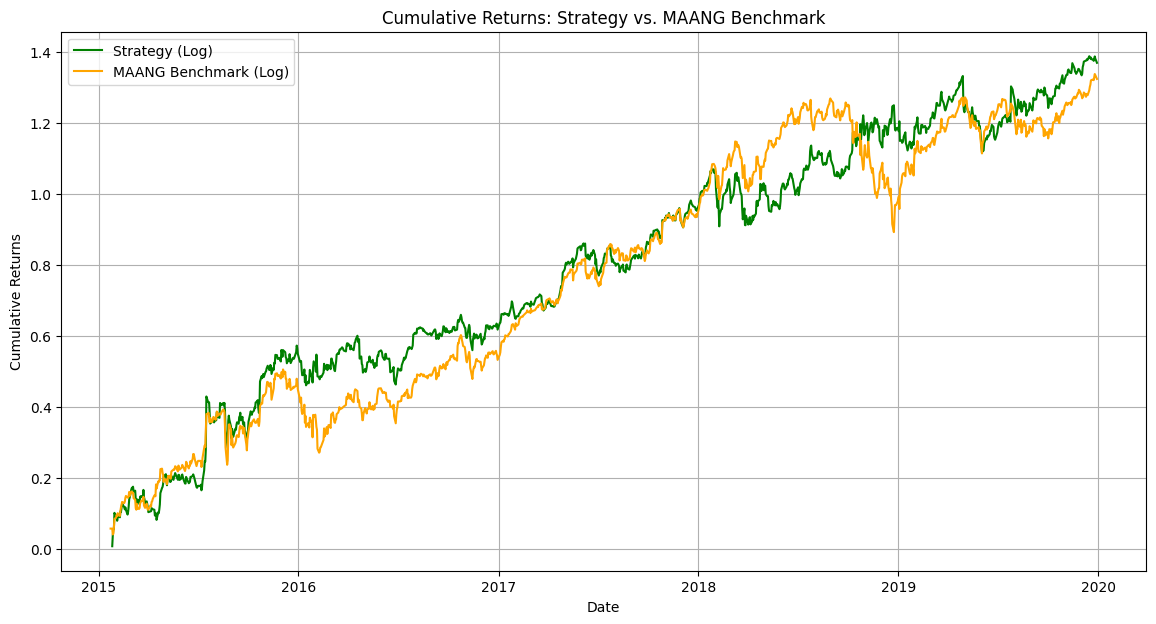

In [28]:
# Combine the cumulative returns from both portfolios using inner join
combined_data = pd.concat([
    strategy_portfolio['cumulative returns'],
    benchmark_portfolio['cumulative returns']
], axis=1, join='inner')

# Rename the columns for clarity
combined_data.columns = ['Strategy (Log)', 'MAANG Benchmark (Log)']

plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Strategy (Log)'], label='Strategy (Log)', color='green')
plt.plot(combined_data.index, combined_data['MAANG Benchmark (Log)'], label='MAANG Benchmark (Log)', color='orange')
plt.title('Cumulative Returns: Strategy vs. MAANG Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


# Visualisation of drawdowns of strategy

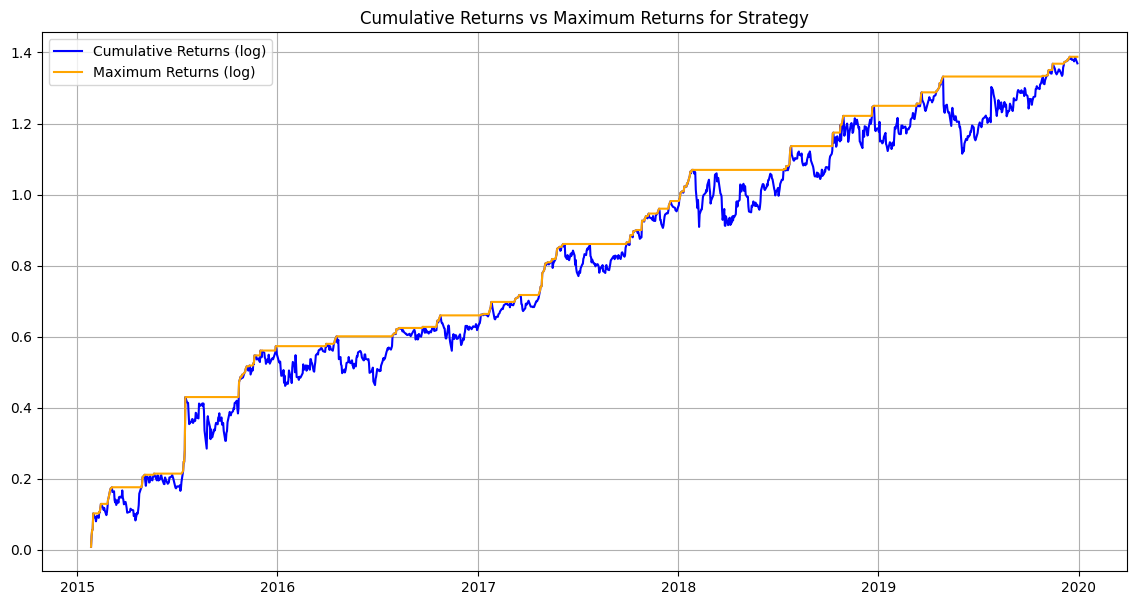

In [31]:
combined_data = pd.concat([strategy_portfolio['cumulative returns'], strategy_portfolio['maximum returns']], axis=1, join='inner')

plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['cumulative returns'], label='Cumulative Returns (log)', color='blue')
plt.plot(combined_data.index, combined_data['maximum returns'], label='Maximum Returns (log)', color='orange')
plt.title('Cumulative Returns vs Maximum Returns for Strategy')
plt.legend()
plt.grid()
plt.show()
